<a href="https://colab.research.google.com/github/meashu31/AIML-Capstone-CV9/blob/Vadhi_master/Unet_Models_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Gogle Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
pip install segmentation-models

In [25]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import data_utils
import numpy as np
from PIL import Image
from keras.utils.layer_utils import count_params
from tabulate import tabulate
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import ipywidgets as widgets
import pandas as pd
from IPython.display import clear_output
import calendar
import time
import datetime
import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import *

In [7]:
path = '/content/drive/My Drive/Capstone/Model_Weights/'
os.chdir(path) #changing the current directory path to the project direcotry where the dataset is available

im_path = '/content/drive/My Drive/Capstone/data/images/'
mask_path = '/content/drive/My Drive/Capstone/data/masks/'
train_list = os.listdir(im_path)
mask_list = os.listdir(mask_path)
print(len(train_list))
print(len(mask_list))

26684
26684


In [81]:
X_train, X_val = train_test_split(train_list[:100], test_size=0.20, random_state=53)
print('Length of training data:',len(X_train),'\nLength of validation data:',len(X_val))

Length of training data: 80 
Length of validation data: 20


In [9]:
class DataGenerator(data_utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path, mask_path,preprocessinput, batch_size=32, dim=(1024, 1024),
                 n_channels=1, shuffle=True,resize=False):
        """Initialization
        self.list_IDs = List of all unique patient Ids
        self.image_path = path to image folder
        self.mask_path = path to mask folder
        self.batch_size = batch_size
        self.dim = dimenstion for each input image
        self.n_channels = no.of channels per image
        self.resize = if true, will resize the input image to self.dim
        self.shuffle = True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.TempList = list_IDs
        self.image_path = image_path
        self.mask_path = mask_path
        self.PreProcess = preprocessinput
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.resize = resize
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        if len(list_IDs_temp)==0:
          print('Trying to access an empty batch. No image left to iterate over. Try changing the batch index')
          return None
        else:
          # Generate data
          X, y = self.__pixel_generation(list_IDs_temp)

          return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __pixel_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        ''' Initialization
         *self.dim is a variable length parameter. It can vary based on the size of image'''
        
        x_image = np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        x_channels = np.empty((self.dim[0],self.dim[1],3))
        y_mask = np.empty((self.batch_size, *self.dim))
        ID_List = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            if self.resize == True:
              x_frame = Image.open(self.image_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
              y_frame = Image.open(self.mask_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
            else:
              x_frame = Image.open(self.image_path + ID)
              y_frame = Image.open(self.mask_path + ID)
            #print(np.array(x_frame).dtype)
            # Store images
            for z in range(3):
              x_channels[:,:,z] = np.array(x_frame)
            
            x_image[i,] = self.PreProcess(np.array(x_channels, dtype=np.float32))
            # Store masks
            temp = np.array(y_frame)
            temp = np.where(temp > 0 , 1, y_frame)           
            y_mask[i,] = temp
            # Store ID
        return x_image, y_mask

## Backboned-UNet

In [78]:
def create_model(Backbone='vgg16',pretrained=True,ShowSummery=False,TrainModel=True,TestModel=True):
  # preprocess input
  PreprocessInput = get_preprocessing(Backbone)
  x_train = DataGenerator(list_IDs=X_train , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)
  x_val = DataGenerator(list_IDs=X_val , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)

  # define model
  model = Unet(Backbone, encoder_weights='imagenet', input_shape=(224, 224, 3))
  ##-------------------getLast layer and add reshape----------------------
  LastLayerIdx = len(model.layers) - 1
  LastLayerName = model.layers[LastLayerIdx].name
  for layer in model.layers:
    layer.trainable = not pretrained
    LastLayer = model.get_layer(LastLayerName).output
    x = Reshape((224, 224))(LastLayer)

  model = Model(inputs=model.input, outputs=x)
  # Model Overview
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)

  print(tabulate([['Model', 'UNet'],\
                          ['BackBone', Backbone],\
                          ['Number of Layers', len(model.layers)],\
                          ['Total params', model.count_params()],\
                          ['Trainable params', trainable_count],\
                          ['Non-trainable params', non_trainable_count]],\
                          headers=['Header', 'Value'], tablefmt='orgtbl'))
  print()
  print()
  #If Choosen Show Summery
  if ShowSummery: model.summary()
  if TrainModel:
    # Compile model
    model.compile('Adam', loss=bce_jaccard_loss, metrics=['accuracy',iou_score])
    # checkpoint
    ts = calendar.timegm(time.gmtime())
    readable = datetime.datetime.fromtimestamp(ts).isoformat()
    filepath = path + Backbone + "/model-"+ readable + ".h5"
    checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
    stop = EarlyStopping(monitor="loss", patience=5, mode="min")
    model.fit(x_train,
              epochs=5,
              steps_per_epoch = len(x_train)/2,
              validation_data=x_val,
              validation_steps = len(x_train)/3*2,
              callbacks= [checkpoint, stop])
  if TestModel:
    test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
    test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)
    model.compile('Adam', loss=bce_jaccard_loss, metrics=['accuracy',iou_score])
    n = 0
    sample_image = test_gen[n][0][0]
    sample_image_redim = np.expand_dims(sample_image, axis=0)
    region = model.predict(sample_image_redim)
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
    ax1.imshow(sample_image[:,:,0], cmap = plt.cm.bone)
    ax1.set_title('Input Image')
    ax1.axis('off')
    ax2.imshow(test_gen[n][1][0], cmap = plt.cm.bone)
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    ax3.imshow(region[0], cmap = plt.cm.bone)
    ax3.set_title('Predicted Mask (no threshold applied)')
    ax3.axis('off')
    plt.show()

In [57]:
print(tabulate([['UNet', 'VGG-16', 67, 23752273],\
                ['UNet', 'VGG-19', 70, 29061969],\
                ['UNet', 'ResNet-18', 128, 14340570],\
                ['UNet', 'ResNet-34', 200, 24456154],\
                ['UNet', 'ResNet-50', 232, 32561114],\
                ['UNet', 'ResNet-101', 419, 51605466],\
                ['UNet', 'ResNet-152', 606, 67295194],\
                ['UNet', 'DenseNet-121', 469, 12144977],\
                ['UNet', 'DenseNet-169', 637, 19519825],\
                ['UNet', 'DenseNet-201', 749, 26378577],\
                ['UNet', 'Inception-V3', 353, 29933105],\
                ['UNet', 'Inception-ResNet-V2', 822, 62061553],\
                ['UNet', 'MobileNet', 129, 8336337]],
                headers=['Model', 'Backbone', 'Number of Layers', 'Total Parameters'], tablefmt='orgtbl',stralign="center", numalign="center"))

|  Model  |      Backbone       |  Number of Layers  |  Total Parameters  |
|---------+---------------------+--------------------+--------------------|
|  UNet   |       VGG-16        |         67         |      23752273      |
|  UNet   |       VGG-19        |         70         |      29061969      |
|  UNet   |      ResNet-18      |        128         |      14340570      |
|  UNet   |      ResNet-34      |        200         |      24456154      |
|  UNet   |      ResNet-50      |        232         |      32561114      |
|  UNet   |     ResNet-101      |        419         |      51605466      |
|  UNet   |     ResNet-152      |        606         |      67295194      |
|  UNet   |    DenseNet-121     |        469         |      12144977      |
|  UNet   |    DenseNet-169     |        637         |      19519825      |
|  UNet   |    DenseNet-201     |        749         |      26378577      |
|  UNet   |    Inception-V3     |        353         |      29933105      |
|  UNet   | 

In [21]:
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider,Button,Output

BackboneDrop = Dropdown(options=[('Select', ""),("VGG-16", "vgg16"),("VGG-19", "vgg19"),
                           ("ResNet-18","resnet18"),("ResNet-34","resnet34"),
                           ("ResNet-50","resnet50"),("ResNet-101","resnet101"),
                           ("ResNet-152","resnet152"),("DenseNet-121","densenet121"),
                           ("DenseNet-169","densenet169"),("DenseNet-201","densenet201"),
                           ("Inception V3","inceptionv3"),("Inception ResNet V2","inceptionresnetv2"),
                           ("MobileNet","mobilenet")])
PreTrainedDrop = Dropdown(options=[('Yes', True),("No", False)])
SummeryDrop = Dropdown(options=[('Yes', True),("No", False)])
TrainModel = Dropdown(options=[('Yes', True),("No", False)])
TestModel = Dropdown(options=[('Yes', True),("No", False)])
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')
output = widgets.Output()
out = Output()
display(out)
form_items = [
    Box([Label(value='Select Backbone'),BackboneDrop], layout=form_item_layout),
    Box([Label(value='Use PreTrained Weights'),PreTrainedDrop], layout=form_item_layout),
    Box([Label(value='Show Model Summary'),SummeryDrop], layout=form_item_layout),
    Box([Label(value='Train Model'),TrainModel], layout=form_item_layout),
    Box([Label(value='Test Model'),TestModel], layout=form_item_layout)]

form = Box(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='27%'
))
form



Output()

Box(children=(Box(children=(Label(value='Select Backbone'), Dropdown(options=(('Select', ''), ('VGG-16', 'vgg1…

UNet Model will be generated with UnTrained densenet121 as backbone, Summery will not be shown and Model will be trained

| Header               | Value       |
|----------------------+-------------|
| Model                | UNet        |
| BackBone             | densenet121 |
| Number of Layers     | 469         |
| Total params         | 12144977    |
| Trainable params     | 12059345    |
| Non-trainable params | 85632       |


Epoch 1/5
5/5 [==============================] - 132s 26s/step - loss: 1.6863 - accuracy: 0.0210 - iou_score: 5.3159e-11 - val_loss: 6.9809 - val_accuracy: 0.0000e+00 - val_iou_score: 2.6856e-11

Epoch 00001: loss improved from inf to 1.68632, saving model to /content/drive/My Drive/Capstone/Model_Weights/densenet121/model-2020-06-19T10:24:05.h5
Epoch 2/5
5/5 [==============================] - 83s 17s/step - loss: 1.4502 - accuracy: 0.0529 - iou_score: 7.0104e-11 - val_loss: 8.9492 - val_accuracy: 6.3776e-04 - val_iou_score: 2.8588e-11

Epoch 00002: loss imp

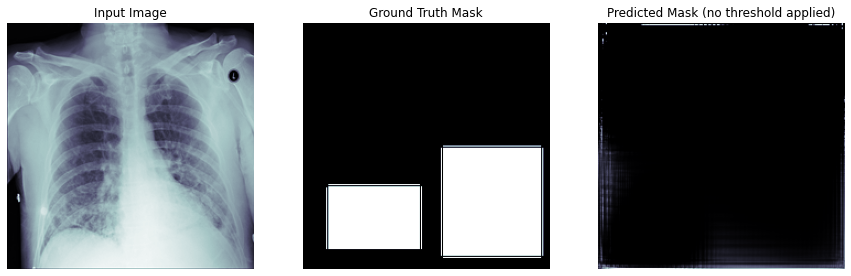

In [82]:
if BackboneDrop.value == "":
  print("Please select as valied Backbone")
  print()
else:
  if PreTrainedDrop.value:
    PretrainText = "Trained"
  else:
    PretrainText = "UnTrained"

  if SummeryDrop.value:
    SummeryText = "Summery will be shown"
  else:
    SummeryText = "Summery will not be shown"

  if TrainModel.value:
    TrainText = "Model will be trained"
  else:
    TrainText = "Model will not be trained"

  print("UNet Model will be generated with",PretrainText,BackboneDrop.value,"as backbone,",SummeryText,"and",TrainText)
  print()
  create_model(Backbone=BackboneDrop.value,pretrained=PreTrainedDrop.value,ShowSummery=SummeryDrop.value,TrainModel=TrainModel.value,TestModel=TestModel.value)
